# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)

(4827, 32, 32, 3)
(4827, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
543/543 [==============================] - 7s 13ms/step - loss: 0.1437 - accuracy: 0.8755 - val_loss: 0.0194 - val_accuracy: 0.9793
Epoch 2/30
543/543 [==============================] - 7s 13ms/step - loss: 0.0177 - accuracy: 0.9701 - val_loss: 0.0314 - val_accuracy: 0.9876
Epoch 3/30
543/543 [==============================] - 10s 18ms/step - loss: 0.0103 - accuracy: 0.9751 - val_loss: 0.0158 - val_accuracy: 0.9420
Epoch 4/30
543/543 [==============================] - 11s 19ms/step - loss: 0.0074 - accuracy: 0.9777 - val_loss: 0.0064 - val_accuracy: 0.9731
Epoch 5/30
543/543 [==============================] - 15s 27ms/step - loss: 0.0051 - accuracy: 0.9830 - val_loss: 0.0073 - val_accuracy: 0.9772
Epoch 6/30
543/543 [==============================] - 17s 31ms/step - loss: 0.0038 - accuracy: 0.9848 - val_loss: 0.0031 - val_accuracy: 0.9938
Epoch 7/30
543/543 [==============================] - 18s 33ms

### Step 1: Learing result
 
* Visualization of the training and validation results

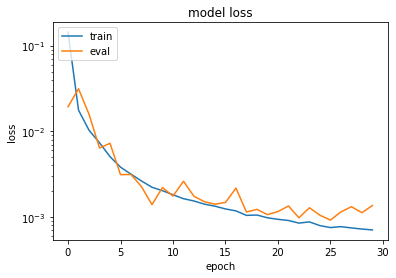

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Epoch 1/160
543/543 [==============================] - 19s 35ms/step - loss: 0.0347 - accuracy: 0.9480 - val_loss: 0.0118 - val_accuracy: 0.9627
Epoch 2/160
543/543 [==============================] - 19s 36ms/step - loss: 0.0071 - accuracy: 0.9692 - val_loss: 0.0066 - val_accuracy: 0.9772
Epoch 3/160
543/543 [==============================] - 19s 34ms/step - loss: 0.0047 - accuracy: 0.9774 - val_loss: 0.0043 - val_accuracy: 0.9731
Epoch 4/160
543/543 [==============================] - 20s 37ms/step - loss: 0.0037 - accuracy: 0.9827 - val_loss: 0.0032 - val_accuracy: 0.9855
Epoch 5/160
543/543 [==============================] - 21s 39ms/step - loss: 0.0034 - accuracy: 0.9839 - val_loss: 0.0060 - val_accuracy: 0.9876
Epoch 6/160
543/543 [==============================] - 21s 38ms/step - loss: 0.0027 - accuracy: 0.9839 - val_loss: 0.0029 - val_accuracy: 0.9896
Epoch 7/160
543/543 [==============================] - 21s 38ms/step - loss: 0.0028 - accuracy: 0.9837 - val_loss: 0.0020 - val_ac

543/543 [==============================] - 21s 38ms/step - loss: 7.3183e-04 - accuracy: 0.9942 - val_loss: 8.8672e-04 - val_accuracy: 0.9959
Epoch 57/160
543/543 [==============================] - 21s 40ms/step - loss: 7.5711e-04 - accuracy: 0.9945 - val_loss: 9.3063e-04 - val_accuracy: 0.9793
Epoch 58/160
543/543 [==============================] - 21s 39ms/step - loss: 7.2245e-04 - accuracy: 0.9931 - val_loss: 8.1254e-04 - val_accuracy: 0.9917
Epoch 59/160
543/543 [==============================] - 22s 41ms/step - loss: 7.1197e-04 - accuracy: 0.9924 - val_loss: 9.4257e-04 - val_accuracy: 0.9979
Epoch 60/160
543/543 [==============================] - 21s 39ms/step - loss: 7.1660e-04 - accuracy: 0.9929 - val_loss: 9.7077e-04 - val_accuracy: 0.9814
Epoch 61/160
543/543 [==============================] - 22s 40ms/step - loss: 7.1812e-04 - accuracy: 0.9942 - val_loss: 0.0013 - val_accuracy: 0.9855
Epoch 62/160
543/543 [==============================] - 21s 39ms/step - loss: 7.0204e-04 - ac

543/543 [==============================] - 13s 25ms/step - loss: 5.3616e-04 - accuracy: 0.9949 - val_loss: 8.8533e-04 - val_accuracy: 0.9959
Epoch 110/160
543/543 [==============================] - 13s 23ms/step - loss: 5.1944e-04 - accuracy: 0.9952 - val_loss: 8.0267e-04 - val_accuracy: 0.9896
Epoch 111/160
543/543 [==============================] - 12s 22ms/step - loss: 5.3286e-04 - accuracy: 0.9952 - val_loss: 8.9843e-04 - val_accuracy: 0.9959
Epoch 112/160
543/543 [==============================] - 13s 24ms/step - loss: 5.2133e-04 - accuracy: 0.9965 - val_loss: 9.1684e-04 - val_accuracy: 0.9959
Epoch 113/160
543/543 [==============================] - 7577s 14s/step - loss: 5.1873e-04 - accuracy: 0.9954 - val_loss: 8.9202e-04 - val_accuracy: 0.9938
Epoch 114/160
543/543 [==============================] - 11s 21ms/step - loss: 5.2295e-04 - accuracy: 0.9959 - val_loss: 8.6529e-04 - val_accuracy: 0.9959
Epoch 115/160
543/543 [==============================] - 10s 19ms/step - loss: 5.20

### Overall Learing results (Step 1 & Step 2)

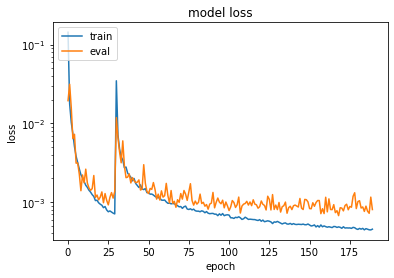

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(loss_ges)
plt.semilogy(val_loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
i = 0
deviation_max_list = 0.05

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))
    i+=1

res = np.asarray(res)
res_step_1 = res

data_resize_all\7.6_3851_analog4_20200821-235348.jpg 0.76 0.8256126156668623 -0.06561261566686227
data_resize_all\7.7_3893_analog4_20200822-014115.jpg 0.77 0.821155917233429 -0.05115591723342894


## Results

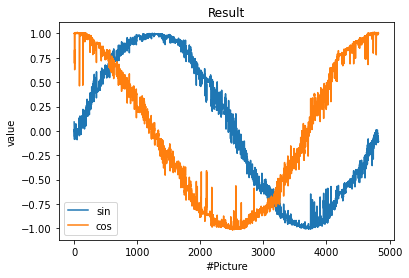

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

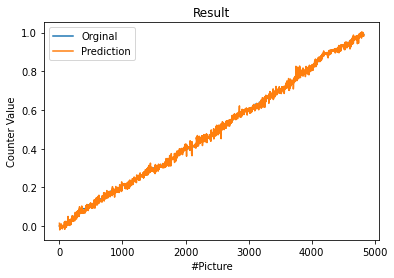

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

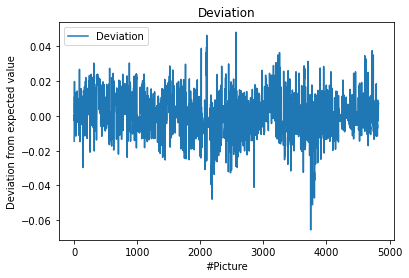

[ 0.001   0.01   -0.0656  0.0482]


In [11]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [12]:
# model.save("CNN_Analog-Readout_Version-6.2.0.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("CNN_Analog-Readout_Version-6.3.0-Small1.tflite", "wb").write(tflite_model)

203904